In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# Implement Action-history-dependent Learning Algorithm

In [2]:
# Problem data.
# Input: n, d1,...,dm

# m is the number of variables
m = 4

# n is the number of time steps
# (constraints that are revealed one by one)
n_values = [24, 48, 96, 248, 500, 1000]

d = np.full(m, 0.25)

In [3]:
# Make results deterministic for debugging
np.random.seed(23)

In [4]:
# Runs Algorithm 3 in paper [5]
def run_alg_3(A, pi, n, m, d):
    start = time.time()

    # Initialize the constraint b_i0 = n d_i for i=1,...,m
    b = n*d

    historical_b = np.zeros((n+1,m))
    historical_b[0] = b

    # Initialize the dual price p1 = 0

    p = np.zeros((m,))

    historical_p = np.zeros((n+1,m))
    historical_p[0] = p

    # Initialize x vector
    x = np.ndarray(0)

    ############################################################

    # For t=1,...,n do
    for t in range(1,n+1):
        if t % 500 == 0:
            now = time.time()
            print("%d iterations completed in %.2f s" % (t, now-start))
        
        #print("\nIteration %d" % (t))
        # Observe (pi_t, a_t)
        a_t = A[:,t-1]
        pi_t = pi[t-1]
        #print("a_t: %s" % (a_t))
        #print("pi_t: %s" % (pi_t))

        # Set:
        # x_t = 1 if r_t > a_t' p_t
        # x_t = 0 if r_t <=  a_t' p_t
        # Save values of x into array
        xt = 0
        if pi_t > np.transpose(a_t)@historical_p[t-1]:
            xt = 1
        x = np.append(x, xt)
        #print("x: %s" % (x))
        #print("len(x): %d" % (len(x)))
        
        if len(x) < n:


            # Update the constraint vector
            b = historical_b[t-1] - np.array(a_t*xt).flatten()
            historical_b[t] = b
            #print("b: %s" % (b))

            # Specify a primal optimization problem
            # max sum from j=1 to t of r_j x_j
            # such that sum from j=1 to t of a_ij x_j <= tb_{it} / (n-t) for i=1,...,m
            # 0<=xj<=1 for j=1,...,t

            # Define variables
            a_up_to_t = A[:,:t]
            pi_up_to_t = pi[:t]
            x_opt = cp.Variable(t)

            # Create constraints.
            constraints = [a_up_to_t @ x_opt <= t*b / (n-t),
                           x_opt >= 0,
                           x_opt <= 1]

            # Form objective.
            obj = cp.Maximize(pi_up_to_t @ x_opt)

            # Form and solve problem.
            prob = cp.Problem(obj, constraints)
            prob.solve()

            # The optimal dual variable (Lagrange multiplier) for
            # a constraint is stored in constraint.dual_value.
            #print("optimal (a_up_to_t @ x_opt <= t*b / (n-t)) dual variable", constraints[0].dual_value)

            p = constraints[0].dual_value

            historical_p[t] = p

    return pi @ x

# Compute dual offline solution

In [5]:
def solve_dual_offline(A, pi, n, m, d):
    
    b = n * d
    
    x_opt = cp.Variable(n)

    # Create constraints.
    constraints = [A @ x_opt <= b,
                   x_opt >= 0,
                   x_opt <= 1]

    # Form objective.
    obj = cp.Maximize(pi @ x_opt)

    # Form and solve problem.
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return pi @ x_opt.value

## Use the setting of Random Input I to assess stopping time and remaining inventory B_n

In [6]:
num_trials = 3

In [7]:
v_vectors = [[0, 0, 1, 1],
            [0, 1, 0, 1]]

w_vectors = [[1, 1, 0, 0],
            [1, 0, 1, 0]]

In [8]:
# This dictionary maps n to an array of dictionaries
# for each trial, we save the results:
# [tn_to_hist_b, tn_to_min_resources_arr,
# tn_to_stopping_time_b2, tn_to_stopping_time_b4,
# tn_to_stopping_time_0, tn_to_bn]
n_to_regret_results = dict()
n_to_expected_regret = dict()

for n in n_values:
    
    regret = list()
    
    for trial in range(num_trials):
        coin_flips = np.random.randint(2, size=int(n/4))

        list_of_vectors = list()
        for i in range(int(n/4)):
            list_of_vectors.append(v_vectors[coin_flips[i]])

        a1 = np.transpose(list_of_vectors)
        a2 = 1 - a1
        A = np.concatenate((a1, a2, a2, a2), axis=1)
        
        pi = np.arange(m)[::-1].repeat(n/4)
        
        alg_3_p = run_alg_3(A, pi, n, m, d)
        dual_offline_p = solve_dual_offline(A, pi, n, m, d)

        regret.append(dual_offline_p - alg_3_p)
        
    n_to_regret_results[n] = regret
    n_to_expected_regret[n] = np.mean(regret)

500 iterations completed in 3.28 s
500 iterations completed in 3.25 s
500 iterations completed in 3.47 s
500 iterations completed in 3.47 s
1000 iterations completed in 8.47 s
500 iterations completed in 3.33 s
1000 iterations completed in 8.19 s
500 iterations completed in 3.32 s
1000 iterations completed in 7.94 s


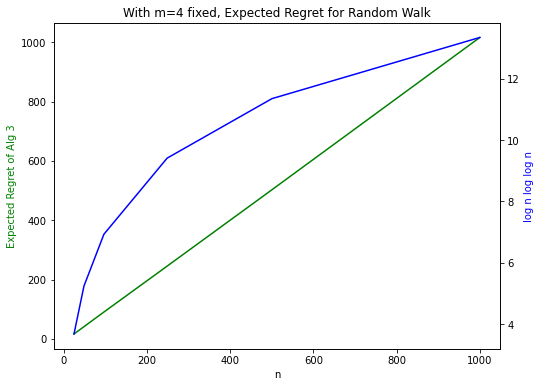

In [9]:
fig, ax1 = plt.subplots(figsize=(8,6))


ax2 = ax1.twinx()

x = list(n_to_expected_regret.keys())
y1 = list(n_to_expected_regret.values())
y2 = [np.log(n)*np.log(np.log(n)) for n in x]

ax1.plot(x, y1, 'g-', label="Expected Regret of Alg 3")
ax2.plot(x, y2, 'b-', label='log n log log n')
ax1.set_xlabel("n")
ax1.set_ylabel("Expected Regret of Alg 3", color='g')
ax2.set_ylabel("log n log log n", color='b')
plt.title("With m=%d fixed, Expected Regret for Random Walk" % (m))
#plt.legend()

plt.show()